In [5]:
%config IPCompleter.greedy=True

In [6]:
#######################################################################################
#   Import Libraries needed
#######################################################################################

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn import preprocessing
import pandas as pd
import numpy as np
from os import path
import time
import gdown

In [7]:
#######################################################################################
#   Load Training Dataset
#######################################################################################
tinit = time.time()

# read train data set
# url = 'https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view?usp=sharing'
# path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
# output = "twitterData.csv"
# gdown.download(path, output, quiet=False)
%time twitter_data = pd.read_csv("../data/twitterData.csv")

Wall time: 2.71 s


In [8]:
# Check form of data
twitter_data.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


In [9]:
# Set part of dataset to be transformed
twitter_data_subset = twitter_data  #[0:200]

In [10]:
#######################################################################################
#   Text preprocessing and transformation of string labels to numeric
#######################################################################################

# Transform "0 and 4" categories to boolean for binary classification
le = preprocessing.LabelEncoder()
y = le.fit_transform(twitter_data_subset["target"])
y = np.reshape(y,(y.shape[0],1))
# # Show the "transformed" categories
# y = le.transform(twitter_data_subset["target"])

In [11]:
### Preprocess tweets text before converting to numerical ###
import re

def preprocessText(x):
    # Convert to lower case
    x = str(x).lower()
    # # Remove url links
    x = re.sub(r'http\S+', '', x)
    # Remove @ tags refer to names of users
    x = re.sub(r'\S*@\S+', '', x)    
    # Remove underscores
    x = re.sub(r'_', ' ', x)
    # remove special chars
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    if x == '': x = 'unk'
    return x

# Preprocess tweets text
%time twitter_data_subset['text'] = twitter_data_subset['text'].apply(lambda x: preprocessText(x))
print(twitter_data_subset['text'].iloc[1000])

# txt = " ss@notoriuS : we LOVE you all______  -&^%+** of lollll ---in Argentina odygsim@gmail.com!!!"
# protxt = preprocessText(txt)
# print(protxt)


Wall time: 12.6 s
in argentina any can happen lol we miss u


In [12]:
# Pick sentiments to transform to vectors
X = twitter_data_subset['text'].to_numpy()

In [13]:
# Select the part of the dataset to use if it is very large
Xsel = X[:10000] #reshape(len(Xsel),1)
ysel = np.squeeze(y[:10000]) #[1:10000].copy()

In [14]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from tqdm import tqdm # for progressbar

import spacy
from spacy.tokens import Doc

class TextToEmbeddingsTransformer(TransformerMixin, BaseEstimator):
    """ A transformer that returns the sentence embedding based on word embeddings
    produced by spacy library (GloVe embeddings based)
    Parameters
    ----------
    demo_param : str, default='demo'
        A parameter used for demonstation of how to pass and store paramters.
    Attributes
    ----------
    n_features_ : int
        The number of features of the data passed to :meth:`fit`.
    """
    def __init__(self, embeddingCalculator='average', 
                 wordEmbeddingsDict={},
                 temporaryEmbeddingsFile='',
                 vocabulary="en_core_web_sm"):
        
        self.embeddingCalculator = embeddingCalculator
        self.temporaryEmbeddingsFile = temporaryEmbeddingsFile # 'vecsfile.npy'
        self.vocabulary = vocabulary
        self.nlp = spacy.load(vocabulary)
        self.embeddingsDict = wordEmbeddingsDict

    def fit(self, X, y=None):
        """ Setting the data (X) to being transformed
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The transformer input samples.
        y : None

        Returns
        -------
        self : object
            Returns self.
        """
        # X = check_array(X, accept_sparse=True)

        self.n_features_ = X.shape[0]

        # Return the transformer
        return self

    def transform(self, X):
        """ Takes the input data text (each row is a sentence consisted of words)
        and uses spacy's nlp to turn each word to an embedding. Then it uses the
        'average','max' or 'min' according to user's preference to outcome the sentence
        embedding based on the word embeddings
        Parameters
        ----------
        X : {array-like, sparse-matrix}, shape (n_samples, n_features)
            The transforme input samples.
        Returns
        -------
        X_transformed : array, shape (n_samples, n_features)
            The array containing the sentence embedding of each sentence
            in ``X``.
        """
        # Check is fit had been called
        check_is_fitted(self, 'n_features_')

        # # Input validation
#       # X = check_array(X, accept_sparse=True)

        # Check that the input is of the same shape as the one passed
        # during fit.
        if X.shape[0] != self.n_features_:
            raise ValueError('Shape of input is different from what was seen'
                             'in `fit`')
        
        # Set dictionary to be used
        embeddingsDict = self.embeddingsDict

        
        # Calculate X dataset embeddings or load from file
        if self.temporaryEmbeddingsFile != '' :
            
            print('Loading embedding vectors from file : ' + self.temporaryEmbeddingsFile)
            Xtrans = np.load(self.temporaryEmbeddingsFile, allow_pickle=True)
        
        # Case having an embeddings dictionary
        elif len(self.embeddingsDict)> 0 :
            
            # Select the sentence embedding calculation method from word embeddings
            if self.embeddingCalculator == 'min':
                vector_embedding = lambda singledoc: np.min(
                    [ embeddingsDict[token] 
                     if token in embeddingsDict  
                     else  embeddingsDict['unk'] 
                     for token in singledoc                    
                    ],
                         axis=0)
            elif self.embeddingCalculator == 'max':
                vector_embedding = lambda singledoc: np.max(
                    [ embeddingsDict[token] 
                     if token in embeddingsDict 
                     else  embeddingsDict['unk']
                     for token in singledoc
                    ], axis=0)
            else:
                vector_embedding = lambda singledoc: np.mean(
                    [ embeddingsDict[token] 
                     if token in embeddingsDict 
                     else  embeddingsDict['unk']
                     for token in singledoc
                    ], axis=0)
                
#             # Set it up as an extension
#             if not Doc.has_extension('vector_except_stopwords'):
#                 Doc.set_extension("vector_except_stopwords", getter=vector_except_stopwords)
            
            # Calc sentences embeddings
            XtransArray =[]
            # Show progress bar
            pbar = tqdm( total=len(X) )
            pbar.clear()
            
            # Convert docs to vector embeddings
            for doc in X:
                XtransArray.append(vector_embedding(doc))
                pbar.update(1)
            
            pbar.close()
            
            # Convert to numpy array
            Xtrans = np.array(XtransArray)

        # Case using spacy's embeddings
        else:
            
            # Select the sentence embedding calculation method from word embeddings
            if self.embeddingCalculator == 'min':
                vector_except_stopwords = lambda singledoc: np.min(
                    [token.vector for token in singledoc if not token.is_stop ], axis=0)
            elif self.embeddingCalculator == 'max':
                vector_except_stopwords = lambda singledoc: np.max(
                    [token.vector for token in singledoc if not token.is_stop], axis=0)
            else:
                vector_except_stopwords = lambda singledoc: np.mean(
                    [token.vector for token in singledoc if not token.is_stop], axis=0)
                
            # Set it up as an extension
            if not Doc.has_extension('vector_except_stopwords'):
                Doc.set_extension("vector_except_stopwords", getter=vector_except_stopwords)
            
            # Calc sentences embeddings
            XtransArray =[]
            for doc in self.nlp.pipe(X):
                XtransArray.append(doc._.vector_except_stopwords)
            
            # Convert to numpy array
            Xtrans = np.array(XtransArray)
            
        return Xtrans


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
def build_vector_model(mode='count'):
    if mode == 'count':
        transformer = CountVectorizer()
        method = 'count'
    if mode == 'tfidf':
        transformer =  TfidfVectorizer()
        method = 'tfidf'
    if mode == 'word_embeddings':
        transformer = TextToEmbeddingsTransformer(wordEmbeddingsDict=glove_embedding)
        method = 'wordembed'
    
    print('Using text transformation : ', method)
    return transformer

In [17]:
# Load glove embeddings into dictionary
%time glove = pd.read_csv('..\data\glove.6B\glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
%time glove_embedding = {key: val.values for key, val in glove.T.items()}

Wall time: 4.25 s
Wall time: 4.35 s


In [18]:
# Pick transformer
# model_pipeline = build_vector_model(mode='word_embeddings')
model_pipeline = build_vector_model(mode='word_embeddings')
# Tranform to vectors
Xsel_transf = model_pipeline.fit_transform(Xsel,ysel)
# Xval_transf = model_pipeline.fit_transform(Xval,yval)

 39%|████████████████████████████▊                                             | 3893/10000 [00:00<00:00, 19252.93it/s]

Using text transformation :  wordembed


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 19026.04it/s]


In [19]:
# Split dataset to train/validation/test set in order
# not to overfit classifiers hyperparameters

from sklearn.model_selection import train_test_split

# Split the train dataset in two equal parts : train_gs , test_gs
# to use in gridsearch for training/testing
Xtrain, Xtotaltest, ytrain, ytotaltest = train_test_split(
    Xsel_transf, ysel, test_size=0.3, random_state=42, shuffle=True, stratify=ysel)
Xval, Xtest, yval, ytest = train_test_split(
    Xtotaltest, ytotaltest, test_size=0.5, random_state=42, shuffle=True, stratify=ytotaltest)

In [20]:
# ysel = np.squeeze(ysel)
# print(ysel)
# glove_embedding['.']

In [21]:
# singledoc = ['bill', 'big']
# # testy = np.min([ glove_embedding[token] 
# #                 if (token in glove_embedding and not token == 'not')
# #                 else glove_embedding['unknown'] 
# #                 for token in singledoc ], axis=0)

# testy2 = np.min([ glove_embedding[token] 
#                      if token in glove_embedding and not token == 'big'
#                      else  glove_embedding['unknown']  
#                  for token in singledoc                 
#                     ], axis=0)
# # print(glove_embedding['unknown'])
# print(glove_embedding['big'])
# print(glove_embedding['bill'])
# print(glove_embedding['unknown'])
# # print(glove_embedding['nurse'])
# print(testy)
# if testy.all() == glove_embedding['unknown'].all():
#     print('yes')
# else:
#     print('no')

In [22]:
# doc = Xtrain[2]
# vector_except_stopwords = lambda singledoc: np.mean(
#     [ glove_embedding[token] 
#      if token in glove_embedding and not token=='big'
#      else  glove_embedding['unk']
#      for token in singledoc
#     ], axis=0)
# vector_except_stopwords(doc)

In [23]:
# with open('fullTransformedSentiments.npy', 'wb') as f:
#     np.save(f, np.array(Xtransf))

In [24]:
# Xtrain_transf[100]

In [25]:
# Xtransf[0].shape


In [26]:
# # zeroarray =[]
# # for i in range(len(X)):
# #     if len(X[i])== 0:
# #         zeroarray.append(i)
# # X[zeroarray[2]]
# twitter_data.iloc[zeroarray[1078]]

In [27]:
# glove_embedding['unk']

In [28]:
# ysel.shape[0]

In [29]:
# import torch
# def describe(x):
#     print("Type: {}".format(x.type()))
#     print("Shape/size: {}".format(x.shape))
#     print("Values: \n{}".format(x))

# batch_size = 12
# input_dim = 1000    
# x_input = torch.rand(batch_size, input_dim)
# describe(x_input)

In [30]:
# from tempfile import TemporaryFile
# vecsfile = TemporaryFile()
# np.save(vecsfile, vecs)

# with open('vecsfile.npy', 'wb') as f:
#     np.save(f, np.array(vecs))
    
# # _ = vecsfile.seek(0)
# import numpy as np
# testy = np.load('vecsfile.npy',allow_pickle=True)
#
# # pd.DataFrame(np.asarray(vecs)).to_csv('textvecs.csv')

In [31]:
# import numpy as np
# df['sent_vectors'] = df['tokenized'].apply(
#   lambda sent: np.mean([token.vector for token in sent if not token.is_stop], axis=0)
# )
# #     lambda sent: sent.vector)
# df['sent_vectors']

# # df = train_data.copy()[1:2000]
# # df['tokenized']= df['text'].apply(sp)

In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [33]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        self.fc = nn.ModuleList()
        self.activF = nn.ModuleList()
        self.hidden_layers = hidden_layers
        
        # Get hidden layers number
        hidden_dims =  hidden_layers['hidden_layers_dims']
        hidden_layers_no = hidden_layers['hidden_layers_no']
        
        # Create a hidden layer for each
        for hidden_layer in range( hidden_layers_no ) :      
            
            if ( hidden_layer == 0) : # Case of input to 1st hidden layer
                self.fc.append( nn.Linear(input_dim, hidden_dims[hidden_layer]) )
                # Non-linearity
                self.activF.append( nn.ReLU() )
            elif (hidden_layer == hidden_layers_no-1): # Case intermediate hidden layer
                self.fc.append( nn.Linear(hidden_dims[hidden_layer-1], output_dim) )
                # Non-linearity
                self.activF.append( nn.ReLU() )
            else: # Case last hidden layer to output
                self.fc.append( nn.Linear(hidden_dims[hidden_layer-1], hidden_dims[hidden_layer]) )
                # Non-linearity
                self.activF.append( nn.ReLU() ) 

    def forward(self, x):
        out = x
        # Forward pass all hidden layers with activation functions
        for layer in range(self.hidden_layers['hidden_layers_no']):
            # Linear function
            out = self.fc[layer](out)
            # Activation function
            out = self.activF[layer](out)
        
        # Return the softmax
        out = F.softmax(out, dim=1)
        
        return out
    

In [34]:
from torch.utils.data import Dataset, DataLoader
from torch import from_numpy, tensor
import numpy as np

class sentimentsDataset(Dataset):
    # Initialize your data, download, etc.
    def __init__(self, X, y):
        self.len = X.shape[0]
#         print(X[15,638], X[15,792], X[15,793], X[15,878])
        self.x_data = torch.from_numpy(X) #.to_sparse() #0:-1]) #.to_sparse() 
#         print(self.x_data[15,638], self.x_data[15,792], self.x_data[15,793], self.x_data[15,878])
        self.y_data = torch.from_numpy(y) #.to_sparse() #) #.to_sparse()
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

class sentimentsPredictionsDataset(Dataset):
    # Initialize your data, download, etc.
    def __init__(self, X, y):
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        self.y_data = torch.from_numpy(y)
    def __getitem__(self, index):
        return self.x_data[index],self.y_data[index]

    def __len__(self):
        return self.len

In [77]:
from sklearn.base import ClassifierMixin
from sklearn.base import BaseEstimator
from sklearn import metrics
import matplotlib.pyplot as plt 
from tqdm import tqdm # for progressbar
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
class FeedForwardNNClassifier(ClassifierMixin, BaseEstimator):
    """ A classifier which implements a feed forward neural net algorithm
    for sentiment analysis.
    Parameters
    ----------
    demo_param : str, default='demo'
        A parameter used for demonstation of how to pass and store paramters.
    Attributes
    ----------
    X_ : ndarray, shape (n_samples, n_features)
        The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
        The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
        The classes seen at :meth:`fit`.
    """
    def __init__(self, input_dim, output_dim, num_epochs=10, 
                 hidden_layers={'hidden_layers_no' : 2, 'hidden_layers_dims': [50, 50]},
                 activation_function = 'ReLU', loss_function='CrossEntropy', 
                 optimizer_name='SGD', learning_rate=0.005,
                 plot_loss=False
                ):
        
        # Set the NN model dimension parameters and initialize FFFNN
        self.input_dim = input_dim
        print('Initializing ffnn clasfr with input dim ', self.input_dim)
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.num_epochs = num_epochs
        self.train_loss = []
        self.plot_loss = plot_loss
        self.optimizer_name = optimizer_name
        self.learning_rate = learning_rate
        
        # Select loss function
        if loss_function == 'CrossEntropy':
            self.loss_function=nn.CrossEntropyLoss()
        elif loss_function == 'MeanSquaredError':
            self.loss_function = nn.MSELoss
        elif loss_function == 'MeanAbsoluteError':
            self.loss_function == nn.L1Loss
        elif loss_function == 'BinaryCrossEntropy':
            self.loss_function == nn.BCELoss
        elif loss_function == 'HuberLoss':
            self.loss_function == nn.SmoothL1Loss
        else :
            pass
        
        # Select the activation function
        # SELU > ELU > leaky ReLU (and variants) > ReLU > tanh > logistic (sigmoid)
        #
        if activation_function == 'Sigmoid':
            self.activation_function=nn.Sigmoid()
        elif activation_function == 'HyperbolicTangent':
            self.activation_function = nn.Tanh()
        elif activation_function == 'ReLU': # all ReLU methods need at least He initialization
            self.activation_function = nn.ReLU()
        elif activation_function == 'LeakyReLU': # a can be 0.01 - 0.2 (lectures suggestions), normally 0.3 (keras)
            self.activation_function = nn.LeakyReLU()
        elif activation_function == 'SoftPlus':
            self.activation_function = nn.Softplus()
        elif activation_function == 'SeLU': 
            # Scaled ELU : very good for dense sequential nets
            # Needs 1) LeCun initialization for hidden layers
            # 2) standarized input features (mean 0, stdev 1)
            self.activation_function = nn.SELU() 
        elif activation_function == 'ELU': # Exponential Linear Unit : usually a=1 / slow to compute
            self.activation_function = nn.ELU()   
        elif activation_function == 'RReLU': # Randomized leaky Relu
            self.activation_function = nn.RReLU()          
        elif activation_function == 'PReLU': # Parametric leaky Relu
            self.activation_function = nn.PReLU()
        else:
            pass

        # Select the optimizer
        
#         self.configure_plots_appearance(plot_loss=plot_loss)

    def train_loss_plot(self):
        epochs = range(1,self.num_epochs+1)
        plt.plot(epochs, self.train_loss, 'g', label='Training loss')
#         plt.plot(epochs, loss_val, 'b', label='validation loss')
        plt.title('Training loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def fit(self, X, y):
        """A reference implementation of a fitting function for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        
        # # Sparse matrix check
        # scipy.sparse.issparse(my_matrix)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        # Store dataset, labels
        self.X_ = X
        self.y_ = y
        
        # Get X dataset input features dimension
        self.input_dim = self.X_[0].shape[0]
        # Initialize FF neural net model
        self.ffnn = FeedforwardNeuralNetModel(input_dim=self.input_dim, 
                                              output_dim=self.output_dim, hidden_layers=self.hidden_layers)
        self.ffnn.to(device)
        
        # Load model to device = GPU
#         self.ffnn.to(device)
        # Assign loss function and optimizer
#         self.loss_function = nn.CrossEntropyLoss()
        
        # Select the activation function
        if self.optimizer_name == 'SGD':
            self.optimizer = optim.SGD(self.ffnn.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'Momentum': # momentum = friction ( 0 high - 1 low - usual 0.9 )
            self.optimizer = optim.SGD(self.ffnn.parameters(), lr=self.learning_rate, momentum=0.9)
        elif self.optimizer_name == 'Nesterov':
            self.optimizer = optim.SGD(self.ffnn.parameters(), lr=self.learning_rate, momentum=0.9, nesterov=True)
        elif self.optimizer_name == 'AdaGrad': # scales down gradient vector along steepest dims 
            # Often stops too early for neural nets - NOT FOR DEEP NN
            self.optimizer = optim.Adagrad()
        elif self.optimizer_name == 'RMSProp': # like Adagrad but using gradients of most recent iterations plus
            # uses exponential decay. Normal alpha working good : 0.9
            self.optimizer = optim.RMSprop(self.ffnn.parameters(), lr=self.learning_rate, alpha=0.9)
        elif self.optimizer_name == 'Adam': # Combination of momentum and Rmsprop
            # Usual values for b1=0.9, b2=0.999 and e=10^(-7)
            # But it is ADAPTIVE algorithm so we can use learning rate = 0.001 without issue
            self.optimizer = optim.Adam ()
        elif self.optimizer_name == 'AdaMax': # differentiation of Adam. To use if we have problems with plain Adam
            self.optimizer = optim.Adamax() 
        elif self.optimizer_name == 'Nadam': # Adam using Nesterov trick - TODO: find how to configure
            self.optimizer = optim.Adam()
            
#         self.optimizer = optim.SGD(self.ffnn.parameters(), lr=0.3)
        
        # Create dataset and dataloader for use from pytorch
        self.dataset = sentimentsDataset(self.X_,self.y_)
        self.train_loader = DataLoader(dataset=self.dataset,
                          batch_size=32,
                          shuffle=True)#,num_workers=2)
        
        # Initialize train loss array
        self.train_loss=[]
        
        # Start training
        for epoch in tqdm( range(self.num_epochs) ):
            
            # Initialize training loss and start keeping record
            train_loss = 0
            
            # Loop over dataset batches
            for index, data in enumerate(self.train_loader, 0) :

                # Get data
                inputs, labels = data

                # Wrap them in Variable
                inputs, labels = inputs, labels

                # Clearing the accumulated gradients
                self.optimizer.zero_grad()

                # Forward pass to get output
                preds = self.ffnn.forward(inputs.float())

                # Calculate Loss: softmax --> cross entropy loss
                loss = self.loss_function(preds, labels)
                
                # Accumulating the loss over time
                train_loss += loss.item()

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                self.optimizer.step()
                
                # # Write loss in file
                # f.write(str((epoch+1)) + "," + str(train_loss / Xtrain.shape[0]))
                # f.write('\n')
        
            # Keep train loss per epoch for plotting purposes
            self.train_loss.append(train_loss/self.X_.shape[0])
            
        # Print loss of epoch
        print(train_loss)
        # Plot train loss if set
        if self.plot_loss: self.train_loss_plot()
        
        # Return the classifier
        return self

    def predict(self, X):
        """ A reference implementation of a prediction for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
#         # Check is fit had been called
#         check_is_fitted(self, ['X_', 'y_'])

#         # Input validation
# #         X = check_array(X)
#         # Dummy y labels
#         y = np.random.randint(2,size=X.shape[0]) #.astype(float)

#         # Create dataset and dataloader for use from pytorch
#         pred_dataset = sentimentsPredictionsDataset(X, y)
#         pred_loader = DataLoader(dataset=pred_dataset,
#                           batch_size=32,
#                           shuffle=False)#,num_workers=2)
        
# #         ypred=np.array()
#         # Loop over all samples
#         for index, data in enumerate(pred_loader, 0):
#             # Get data
#             predInputs, predLabels = data

#             # Wrap them in Variable
#             predInputs, predLabels = predInputs, predLabels

#             # Forward pass to get output
#             preds = self.ffnn(predInputs.float())
# #             print(preds.detach().numpy())
            
#             # Keep predicted labels
# #             ypred = np.append(ypred,torch.argmax(preds, dim=1))
        
#             # Get the probabilities calculated for each class
#             if index == 0 :
#                 ypred_probs = preds.detach().numpy()
#             else:
#                 ypred_probs = np.vstack( ( ypred_probs, preds.detach().numpy() ) )
        
        # Get classes prediction probabilities
        ypred_probs = self.predict_proba(X)
        # Return the prevailing class (argmax)
        ypred = np.argmax(ypred_probs, axis=1)

        return ypred

    def predict_proba(self, X):
        """ A reference implementation of a prediction for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the probability of each class
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
#         X = check_array(X)
        # Dummy y labels
        y = np.random.randint(2,size=X.shape[0]) #.astype(float)

        # Create dataset and dataloader for use from pytorch
        pred_dataset = sentimentsPredictionsDataset(X, y)
        pred_loader = DataLoader(dataset=pred_dataset,
                          batch_size=32,
                          shuffle=False)#,num_workers=2)
        
#         ypred=np.array()
        # Loop over all samples
        for index, data in enumerate(pred_loader, 0):
            # Get data
            predInputs, predLabels = data

            # Wrap them in Variable
            predInputs, predLabels = predInputs, predLabels

            # Forward pass to get output
            preds = self.ffnn(predInputs.float())
#             print(preds.detach().numpy())
            
            # Keep predicted labels
#             ypred = np.append(ypred,torch.argmax(preds, dim=1))
        
            if index == 0 :
                ypred_probs = preds.detach().numpy()
            else:
                ypred_probs = np.vstack( ( ypred_probs, preds.detach().numpy() ) )

        return ypred_probs
    
#     def configure_plots_appearance(plot_roc_curve=False, plot_loss=False):
#         self.plot_loss = plot_loss

    

        
    

In [114]:
mynn_clasf = FeedForwardNNClassifier(input_dim=100, output_dim=2, num_epochs=100, 
                                     optimizer_name='Momentum', learning_rate=0.001, plot_loss=True)

Initializing ffnn clasfr with input dim  100


In [115]:
# X = np.random.rand(100,5)
# y = np.random.randint(5,size=(100,))
# np.unique(y)
# ytrain
# Xtrain[15,12021]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]

150.78931385278702


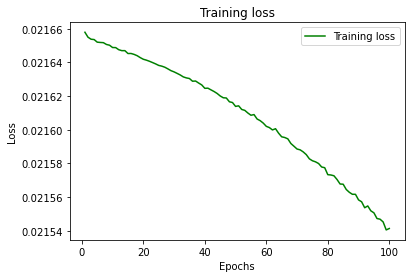

FeedForwardNNClassifier(activation_function=ReLU(), input_dim=100,
                        learning_rate=0.001, loss_function=CrossEntropyLoss(),
                        num_epochs=100, optimizer_name='Momentum', output_dim=2,
                        plot_loss=True)

In [116]:
mynn_clasf.fit(Xtrain,ytrain)

In [117]:
from sklearn import metrics
import matplotlib.pyplot as plt 

def ffnn_roc_curve_plot(y, ypred_probs, pos_label):
    # Get positive sentiments probabilities to use in ROC curve
    ypositive_probs = np.array([yi[1] for yi in ypred_probs])
    # Calc ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y, ypositive_probs, pos_label=pos_label)
    # Display ROC curve
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
    display.plot()  
    plt.show()

In [118]:
# Predict sentiments probabilities
ypred_probs = mynn_clasf.predict_proba(Xtrain)

In [119]:
# ypred_=mynn_clasf.predict(Xtrain)

In [120]:
max(ypred_probs)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

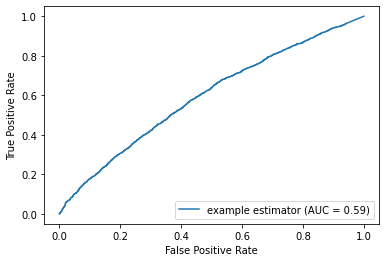

In [121]:
ffnn_roc_curve_plot(ytrain, ypred_probs, pos_label=1)
# # Get positive sentiments probabilities to use in ROC curve
# ypositive_probs = np.array([yi[1] for yi in ypred])
# # Calc ROC curve
# fpr, tpr, thresholds = metrics.roc_curve(ytrain, ypositive_probs, pos_label=1)
# # Display ROC curve
# roc_auc = metrics.auc(fpr, tpr)
# display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,                                          estimator_name='example estimator')
# display.plot()  
# plt.show()


In [122]:
# Get predicted labels and show classification report
ypred_ = np.argmax(ypred_probs,axis=1)
print(classification_report(ytrain,ypred_))

              precision    recall  f1-score   support

           0       0.60      0.06      0.10      3377
           1       0.52      0.96      0.68      3623

    accuracy                           0.53      7000
   macro avg       0.56      0.51      0.39      7000
weighted avg       0.56      0.53      0.40      7000



In [123]:
np.argmax(ypred_probs,axis=1)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [124]:
# Predict sentiments probabilities
yval_pred_probs = mynn_clasf.predict_proba(Xval)

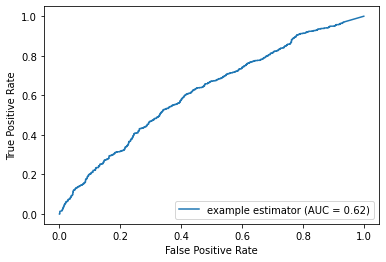

In [125]:
ffnn_roc_curve_plot(yval, yval_pred_probs, pos_label=1)

In [126]:
# Get predicted labels and show classification report
yval_pred_ = np.argmax(yval_pred_probs,axis=1)
print(classification_report(yval,yval_pred_))

              precision    recall  f1-score   support

           0       0.68      0.07      0.12       724
           1       0.53      0.97      0.68       776

    accuracy                           0.53      1500
   macro avg       0.60      0.52      0.40      1500
weighted avg       0.60      0.53      0.41      1500



In [94]:
# sum(yi==1 for yi in ypred)

In [ ]:
# ytrain

In [ ]:
# Xtrain_transf[4]

In [ ]:
# count =0
# for i in range(100):
#     for j in range(100):
#         if (Xtrain_transf[i] == Xtrain_transf[j]).all():
#             count+=1

# print(count)

In [ ]:
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# output = loss(input, target)
# output.backward()